.. _thindisk:

Note: This tutorial is available as a python notebook [here](https://github.com/mneeleman/qubefit/blob/master/doc/nb/ThinDisk.ipynb).

# Fitting a ThinDisk Model

The goal of this tutorial is to fit a thin disk model to ALMA observations of a high redshift galaxy. Our scientific aim is to measure the rotational velocity and dispersion of the galaxy. For the data, we will be using the full calibrated continuum-subtracted data cube of the ionized carbon emission from a z=4.26 galaxy ('the Wolfe disk') described in [Neeleman et al. (2020)](https://arxiv.org/abs/2005.09661). The emission from this galaxy appears to have a smooth velocity field, which is consistent with emission emitted by gas within a rotating disk.

To run this example, you will need to have access to the data. Currently the example file is part of the github code and lives in the `examples` folder, because it also is used to verify the code was installed correctly. This might change in future versions, in which case you will need to download the file and add it to the examples folder manually. The fits file `examples/WolfeDiskCube.fits` (15MB) is actually a sub-cube of the full continuum-subtracted data cube, which is signficantly larger (232MB). 

## Setup the model

The first step is to slice the cube to a small enough region surrounding the emission. Calculate or load the variance, load the beam (or PSF) and setting the mask. The second step is to define the model we wish to use to fit this modified data cube within the defined mask and define the initial parameters of the model. Finally we wish to create the model from our initial parameters. These steps are easiest placed inside a function. This function can then be placed into a separate file and loaded with the GUI: `qfgui`. Below is a repeat of the setup file `DiskModel.py` that is in the example folder. For a detailed description of this setup file, see the documentation on creating a setup file.

In [2]:
# import the required modules
import numpy as np
import astropy.units as u
from qubefit.qubefit import QubeFit

# set up the model
def set_model():

    # Initialize the QubeFit Instance
    DataFile = '../../examples/WolfeDiskCube50.fits'
    Qube = QubeFit.from_fits(DataFile)
    Qube.file = DataFile

    # Trimming the Data Cube
    center, sz, chan = [128, 128], [45, 45], [6, 19]
    xindex = (center[0] - sz[0], center[0] + sz[0] + 1)
    yindex = (center[1] - sz[1], center[1] + sz[1] + 1)
    zindex = (chan[0], chan[1])
    QubeS = Qube.get_slice(xindex=xindex, yindex=yindex, zindex=zindex)

    # Calculating the Variance
    QSig = Qube.calculate_sigma()
    QSig = np.tile(QSig[chan[0]: chan[1], np.newaxis, np.newaxis],
                   (1, 2 * sz[1] + 1, 2 * sz[0] + 1))
    QubeS.variance = np.square(QSig)

    # Defining the Kernel
    QubeS.create_gaussiankernel(channels=[0], LSFSigma=0.1)

    # Setting the Mask
    QubeS.create_maskarray(sigma=3, fmaskgrow=0.01)

    # Define the Model
    QubeS.modelname = 'ThinDisk'
    QubeS.intensityprofile[0] = 'Exponential'
    QubeS.velocityprofile[0] = 'Constant'
    QubeS.dispersionprofile[0] = 'Constant'
    
    # Parameters and Priors
    PDict = {'Xcen': {'Value': 45.0, 'Unit': u.pix, 'Fixed': False,
                      'Conversion': None,
                      'Dist': 'uniform', 'Dloc': 35, 'Dscale': 20},
             'Ycen': {'Value': 45.0, 'Unit': u.pix, 'Fixed': False,
                      'Conversion': None,
                      'Dist': 'uniform', 'Dloc': 35, 'Dscale': 20},
             'Incl': {'Value': 45.0, 'Unit': u.deg, 'Fixed': False,
                      'Conversion': (180 * u.deg) / (np.pi * u.rad),
                      'Dist': 'uniform', 'Dloc': 0, 'Dscale': 90},
             'PA': {'Value': 100.0, 'Unit': u.deg, 'Fixed': False,
                    'Conversion': (180 * u.deg) / (np.pi * u.rad),
                    'Dist': 'uniform', 'Dloc': 0, 'Dscale': 360},
             'I0': {'Value': 8.0E-3, 'Unit': u.Jy / u.beam, 'Fixed': False,
                    'Conversion': None,
                    'Dist': 'uniform', 'Dloc': 0, 'Dscale': 1E-1},
             'Rd': {'Value': 1.5, 'Unit': u.kpc, 'Fixed': False,
                    'Conversion': (0.1354 * u.kpc) / (1 * u.pix),
                    'Dist': 'uniform', 'Dloc': 0, 'Dscale': 5},
             'Rv': {'Value': 1.0, 'Unit': u.kpc, 'Fixed': True,  # not used
                    'Conversion': (0.1354 * u.kpc) / (1 * u.pix),
                    'Dist': 'uniform', 'Dloc': 0, 'Dscale': 5},
             'Vmax': {'Value': 250.0, 'Unit': u.km / u.s, 'Fixed': False,
                      'Conversion': (50 * u.km / u.s) / (1 * u.pix),
                      'Dist': 'uniform', 'Dloc': 0, 'Dscale': 1000},
             'Vcen': {'Value': 6.0, 'Unit': u.pix, 'Fixed': False,
                      'Conversion': None,
                      'Dist': 'uniform', 'Dloc': 4, 'Dscale': 20},
             'Disp': {'Value': 80.0, 'Unit': u.km/u.s, 'Fixed': False,
                      'Conversion': (50 * u.km / u.s) / (1 * u.pix),
                      'Dist': 'uniform', 'Dloc': 0, 'Dscale': 300}
             }
    QubeS.load_initialparameters(PDict)

    # Making the Model
    QubeS.create_model()

    return QubeS

Now that we have a function that defines the model and loads the parameters, we can easily load in an instance of ``qubefit``

In [3]:
Cube = set_model()

## Running the MCMC Fitting

Running the fitting code is now a simple function call where we just need to set the number of walkers, the number of steps and the number of parallel processes. In this case, to sufficiently sample the parameter space requires quite a few walkers, as well as enough steps in the chain. We will set the number of walkers to 100 and the number of steps to 1000. This will take quite a long time to run (2.5 hours on a 20-core system), so in this tutorial we will just read in the output file (an HDF5 file) for speed in the next section. You can rerun the code for yourself if you set the variable ``you_are_very_patient`` to ``true``.

In [4]:
you_are_very_patient = False
if you_are_very_patient:
    Cube.run_mcmc(nwalkers=100, nsteps=1000, nproc=20, filename='../../examples/WolfeDiskPar.hdf5')

## Analyzing the Output

After running the fitting routine, we now wish to analyze the results. The first thing that we need to do is to load the data into the qubefit instance. If you ran the fitting procedure, the chain and log-probability are stored automatically in the qubefit instance. If not, you will need to load them from file. To load the output file of the tfitting routine into the qubefit instance, we use the function ``get_chainresults`` with the keyword ``filename``. This function will also calculate some useful quantities, such as median values for each parameter probability distribution function and 1, 2 and 3-'$\sigma$' uncertainties. For convenience, these are given in the same units as the initial parameters (i.e., the physical units not the intrinsic units). Finally the function reruns the function ``create_model``, which updates the model ``Cube.model`` with the model using the median of each of the parameter distributions. 

In [5]:
you_ran_the_fitting_code = False
if you_ran_the_fitting_code:
    Cube.get_chainresults(burnin=0.3)
else:
    # load the qubefit instance, if you didn't already do this before
    Cube = set_model()
    # burnin sets the fraction of intial steps to discard, here we want to look at the full chain,
    # so we are setting it to 0.0. To get reliable estimates on the parameters, you want to discard some
    # of the runs (typically 30% is a good conservative number, see below).
    Cube.get_chainresults(filename='../../examples/WolfeDisk50Par.hdf5', burnin=0.0)

The first thing that we can do is to check the chain for each parameter. Here is the code to look at the chain for three parameters, the x-position of the center, the y-postion of the center, and the rotational velocity. We also plot the log-probability for the chain. In this figure, each line is a single walker, and in this example we have 100 walkers. 

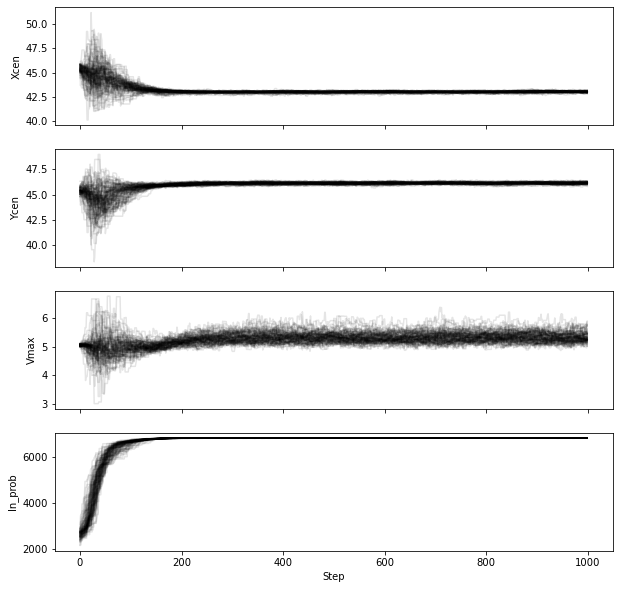

In [6]:
import matplotlib.pyplot as plt
import numpy as np

figure, axs = plt.subplots(nrows=4, ncols=1, sharex=True, figsize=(10, 10))

pars_to_plot = [0, 1, 6] 
nsteps = Cube.mcmcarray.shape[0]
nwalkers = Cube.mcmcarray.shape[1]


# plot each parameter
for idx, par_idx in enumerate(pars_to_plot):
    for walker in np.arange(nwalkers):
        axs[idx].plot(np.arange(nsteps), Cube.mcmcarray[:, walker, par_idx], alpha=0.1, color='k')
    axs[idx].set_ylabel(Cube.mcmcmap[par_idx])

# plot the log_probability
for walker in np.arange(nwalkers):
        axs[-1].plot(np.arange(nsteps), Cube.mcmclnprob[:, walker], alpha=0.1, color='k')
axs[-1].set_ylabel('ln_prob')
axs[-1].set_xlabel('Step')

plt.show()

Note that in this figure, we are plotting the intrinsic units of the parameters (i.e., Vmax is given in pixels and not km/s). The conversion from one to the other is stored in ``Cube.chainpar``. The thing here that we are looking for is to see if the chain has reached convergence. Convergence is a rather hard-to-define term, and more numerical approaches are given in the [emcee documentation](https://emcee.readthedocs.io/en/stable/user/autocorr/). However, we are looking to see at what step the ensamble average does not seem to change for any of the parameters in the model. This step marks the end of the burn-in phase. In our case, it appears the chain has converged after step ~200 (out of 1000), we therefore conservatively remove 30% of the chains as our burn-in phase to estimate the probability distribution functions of each parameter.

In [7]:
Cube.get_chainresults(filename='../../examples/WolfeDisk50Par.hdf5', burnin=0.3)

Now we can look at some of the characteristics of the probability distribution function for each parameter. For instance, the total velocity dispersion along the line of sight 'Disp' has the following information: 

In [8]:
Cube.chainpar['Disp']

{'Median': 84.70743027186644,
 '1Sigma': [82.28748593864957, 87.25928474679459],
 '2Sigma': [79.83900448628935, 89.94748456707963],
 '3Sigma': [77.50548233302094, 92.65854105589592],
 'Best': 85.40119370633211,
 'Unit': Unit("km / s"),
 'Conversion': <Quantity 50. km / (pix s)>}

The median value and 1, 2, and 3-'$\sigma$' uncertainties. That is, these are the 0.13, 2.27, 15.87, 50, 84.13, 97.72, 99.87 percentile ranges of the probability distribution function. Note that the units have been converted into physical units, as defined by the initial parameter dictionary. The 'best' parameter is the value of the parameter space that produces the highest probability. This is **not necessarily** the best parameter to use, as the median of the distribution is often a better indicator of the overall distribution. In this case we can report the median velocity dispersion and 1-$\sigma$ uncertainties as:

$\sigma_v$ = $85^{+2}_{-3}$ km s$^{-1}$

## Making Diagnostic Plots

Besides getting the parameters for the individual parameters, we also want to see if there are dependencies between the parameters. This is easiest done using a corner plot. For this we will import the [corner](https://corner.readthedocs.io/en/latest/) module.

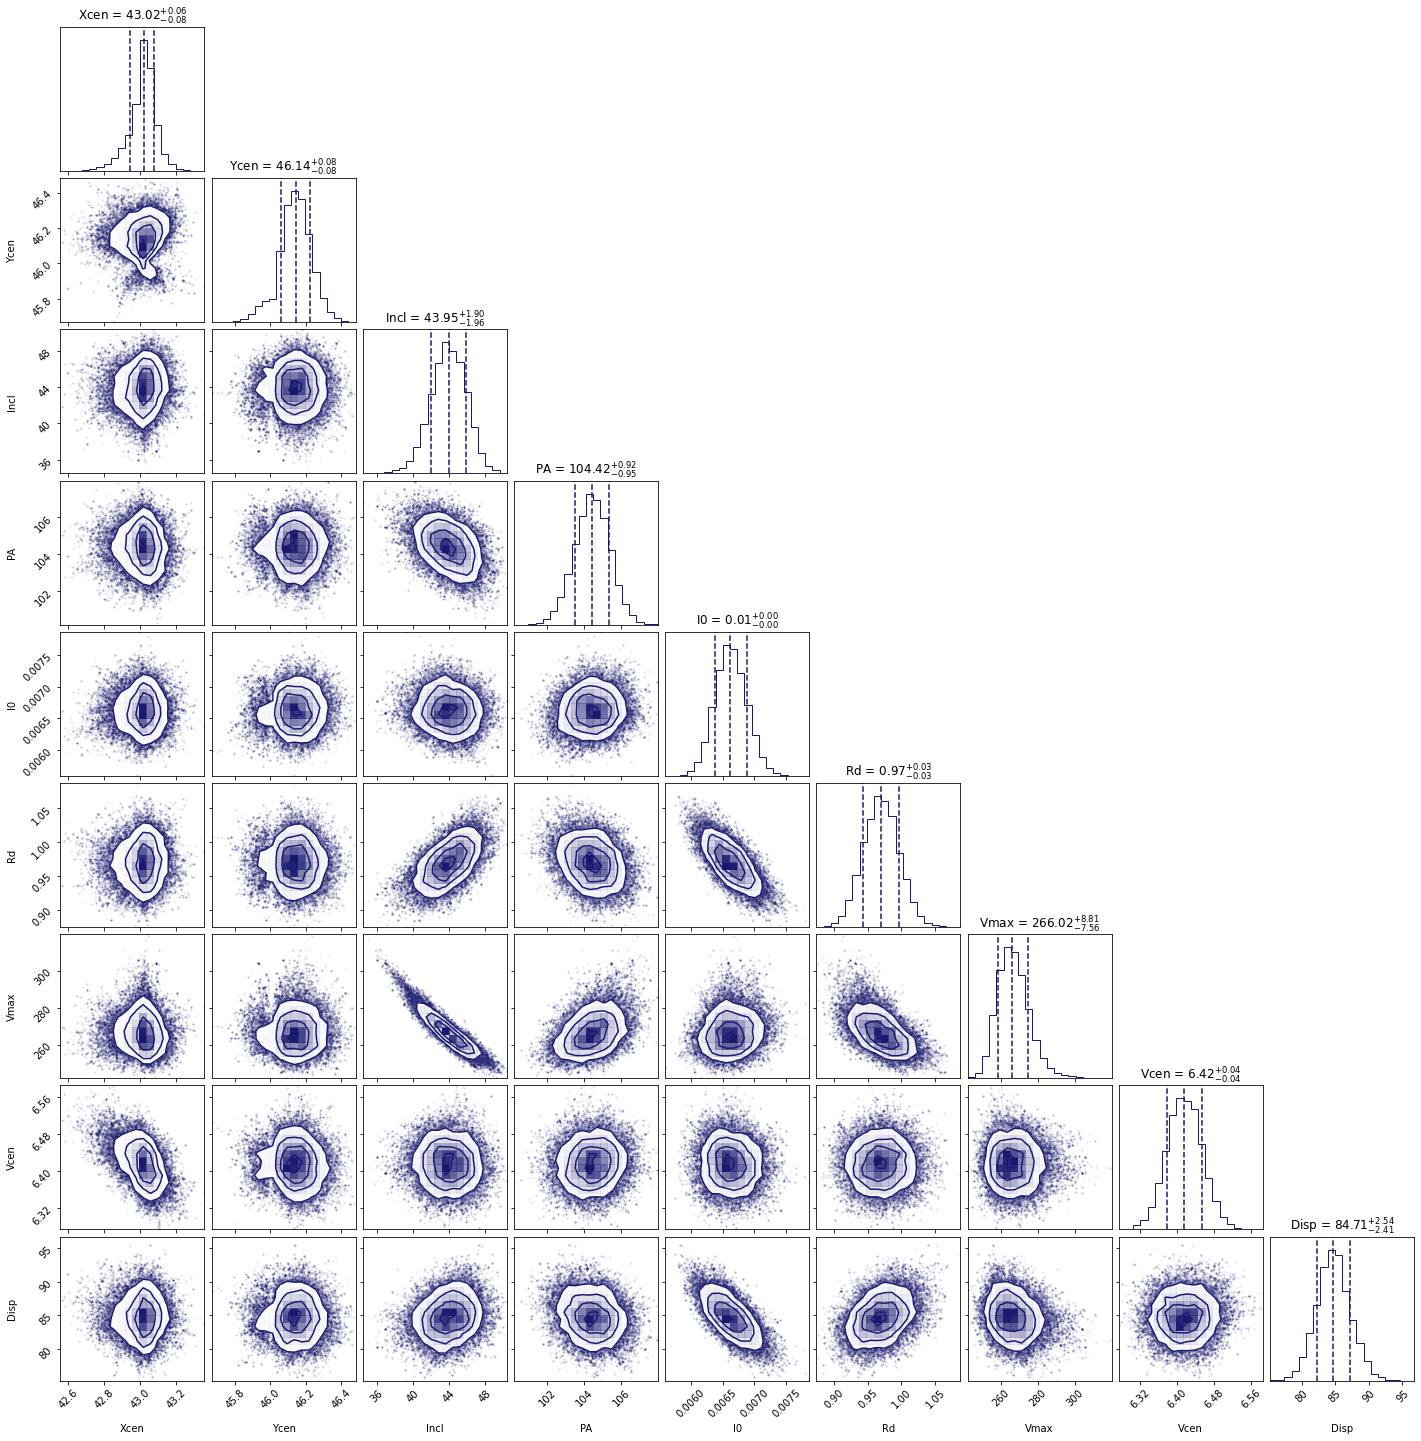

In [9]:
import corner
from copy import deepcopy as dc

parameters = Cube.mcmcmap
labels = Cube.mcmcmap
Chain = dc(Cube.mcmcarray.reshape((-1, Cube.mcmcarray.shape[2])))

# convert to physical units
for key in parameters:
    idx = Cube.mcmcmap.index(key)
    if Cube.initpar[key]['Conversion'] is not None:
        conversion = Cube.initpar[key]['Conversion'].value
        Chain[:, idx] = Chain[:, idx] * conversion

fig = corner.corner(Chain, quantiles=[0.16, 0.5, 0.84], labels=labels,
                    color='midnightblue', plot_datapoints=True, show_titles=True)
plt.show()

In this figure, we can see several parameters that appear to be correlated. For instance, the inclination (*incl*) and the maximum rotational velocity (*Vmax*). This is not surprising, because if we view the disk more edge-on (higher inclination), then the would need a lower rotational velocity to produce the same line-of-sight velocity. Similarly the flux normalization (*I$_0$*) and exponential scale length are inversely correlated, which is needed to keep the total amount of emission roughly constant. This corner plot is not particularly 'pretty', there appears to be a local minimum (e.g., at PA=101 and Disp=100) in which some of the walkers got stuck. For the paper ([neeleman et al. 2020](https://arxiv.org/abs/2005.09661)), we therefore ran the chain much longer with double the number of walkers, which produced a better result. For illustration purposes (and to keep the file size smaller), here we only show this shorter chain.

Another interesting diagnostic plot is the total integrated flux and the velocity field of the data, the model and the residual. This will show how well the model reproduced the general characteristics of the data. 

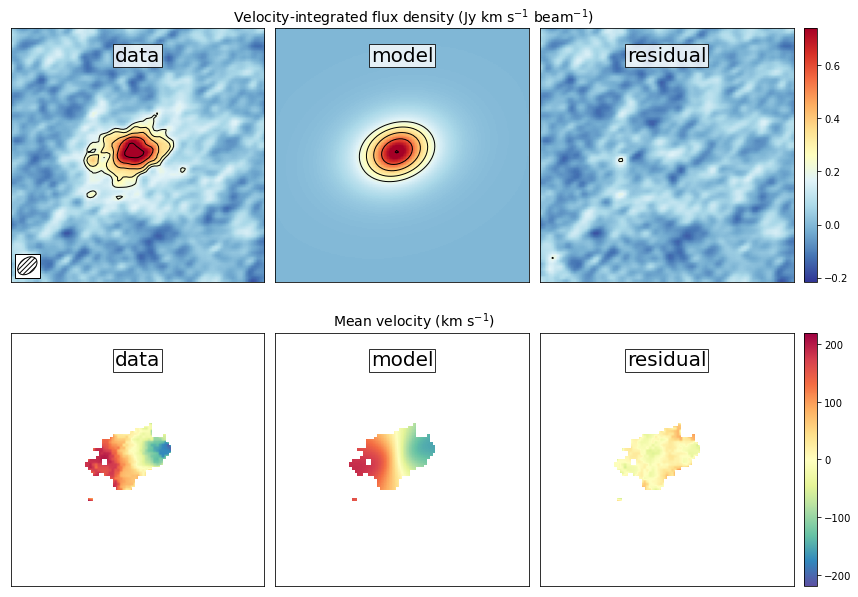

In [10]:
from mpl_toolkits.axes_grid1 import ImageGrid
from qubefit.qfutils import qubebeam
import warnings
warnings.filterwarnings("ignore")

# model, data and residual
Mom0Data = Cube.calculate_moment(moment=0)
Mom0RMS = Mom0Data.calculate_sigma()
Mom0Model = Cube.calculate_moment(moment=0, use_model=True)
Mom0Res = Mom0Data.data - Mom0Model.data

Mask = Mom0Data.mask_region(value=3*Mom0RMS, applymask=False)
CubeClip = Cube.mask_region(value=2*np.sqrt(Cube.variance[:, 0, 0]))
Mom1Data = CubeClip.calculate_moment(moment=1)
Mom1Data = Mom1Data.mask_region(mask=Mask)
Mom1Model = Cube.calculate_moment(moment=1, use_model=True)
Mom1Model = Mom1Model.mask_region(mask=Mask)
Mom1Res = Mom1Data.data - Mom1Model.data

# ranges to plot
vrange = np.array([-3.2 * Mom0RMS, 11 * Mom0RMS])
levels = np.insert(3 * np.power(np.sqrt(2), np.arange(0, 5)), 0, [-4.2, -3]) * Mom0RMS
vrange2 = np.array([-220, 220])

# figure specifics
#fig = plt.figure(figsize=(7.2, 4.67))
fig = plt.figure(figsize=(14, 9))
grid = ImageGrid(fig, (0.1, 0.53, 0.80, 0.45), nrows_ncols=(1, 3), axes_pad=0.15,
                 cbar_mode='single', cbar_location='right', share_all=True)
labels = ['data', 'model', 'residual']
for ax, label in zip(grid, labels):
    ax.set_xticks([]); ax.set_yticks([])
    ax.text(0.5, 0.87, label, transform=ax.transAxes, fontsize=20,
            color='k', bbox={'facecolor': 'w', 'alpha': 0.8, 'pad': 2},
            ha='center')
    
# the moment-zero images
ax = grid[0]
im = ax.imshow(Mom0Data.data, cmap='RdYlBu_r', origin='lower', vmin=vrange[0], vmax=vrange[1])
ax.contour(Mom0Data.data, levels=levels, linewidths=1, colors='black')
ax.add_artist(qubebeam(Mom0Data, ax, loc=3, pad=0.3, fill=None, hatch='/////', edgecolor='black'))
ax = grid[1]
ax.imshow(Mom0Model.data, cmap='RdYlBu_r', origin='lower', vmin=vrange[0], vmax=vrange[1])
ax.contour(Mom0Model.data, levels=levels, linewidths=1, colors='black')
ax = grid[2]
ax.imshow(Mom0Res, cmap='RdYlBu_r', origin='lower',vmin=vrange[0], vmax=vrange[1])
ax.contour(Mom0Res, levels=levels, linewidths=1, colors='black')
plt.colorbar(im, cax=grid.cbar_axes[0], ticks=np.arange(-10, 10) * 0.2)

# the moment-one images
grid = ImageGrid(fig, (0.1, 0.06, 0.80, 0.45), nrows_ncols=(1, 3),
                 axes_pad=0.15, cbar_mode='single', cbar_location='right',
                 share_all=True)
labels = ['data', 'model', 'residual']
for ax, label in zip(grid, labels):
    ax.set_xticks([]); ax.set_yticks([])
    ax.text(0.5, 0.87, label, transform=ax.transAxes, fontsize=20,
            color='k', bbox={'facecolor': 'w', 'alpha': 0.8, 'pad': 2},
            ha='center')
    
ax = grid[0]
im = ax.imshow(Mom1Data.data, cmap='Spectral_r', origin='lower', vmin=vrange2[0], vmax=vrange2[1])
ax = grid[1]
ax.imshow(Mom1Model.data, cmap='Spectral_r', origin='lower', vmin=vrange2[0], vmax=vrange2[1])
ax = grid[2]
ax.imshow(Mom1Res, cmap='Spectral_r', origin='lower',vmin=vrange2[0], vmax=vrange2[1])
plt.colorbar(im, cax=grid.cbar_axes[0], ticks=np.arange(-10, 10) * 100)

# some labels
fig.text(0.5, 0.49, 'Mean velocity (km s$^{-1}$)',
         fontsize=14, ha='center')
fig.text(0.5, 0.96,
         'Velocity-integrated flux density (Jy km s$^{-1}$ beam$^{-1}$)',
         fontsize=14, ha='center')
plt.show()

This figure reveals that the model roughly reproduces the emission and velocity field. In the velocity-integrated flux density, the contours, which start at 2$\sigma$, are almost non-existent in the residual image. This is consistent with the noise in the image. For the velocity field, the average velocity gradient is well-produced by the model. However, the residual still has some variations. This is partly due to the way that the velocity field was estimated (a simple first moment where the cube was clipped at 2$\sigma$), this can produce less reliable velocity fields in low signal to noise observations (see Appendix C of Neeleman et al. 2021 ``link this``). 

The final diagnostic plot that we will look at is the individual channel maps. This will show the most stringent constraints on how well the model fits the data. In this version, we will plot the data, and we will overlay the residuals of each channel map as contours, starting at 2$\sigma$ and increasing in powers of $\sqrt 2$.

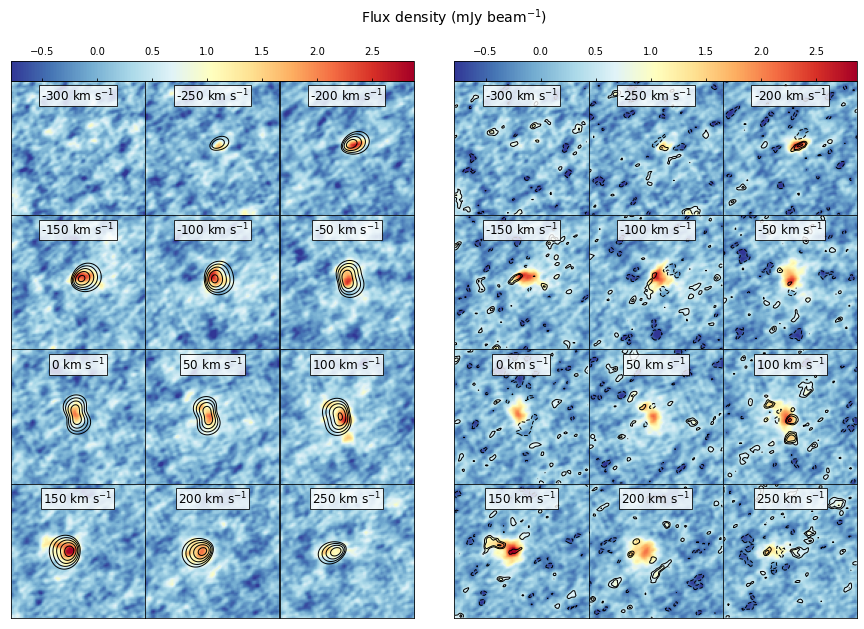

In [11]:
fig = plt.figure(figsize=(14, 11))
grid = ImageGrid(fig, (0.06, 0.09, 0.40, 0.94), nrows_ncols=(4, 3),
                 axes_pad=0.0, cbar_mode='single', cbar_location='top',
                 share_all=True)
CubeRMS = np.sqrt(Cube.variance[:, 0, 0]) * 1E3
MedRMS = np.median(CubeRMS)
vrange = [-3 * MedRMS, 11 * MedRMS]
vel = Cube._getvelocity_()
for idx, channel in enumerate(np.arange(12)):
    ax = grid[idx]
    ax.set_xticks([]); ax.set_yticks([])
    im = ax.imshow(Cube.data[channel, :, :] * 1E3, cmap='RdYlBu_r',
                   origin='lower', vmin=vrange[0], vmax=vrange[1])
    levels = (np.insert(2 * np.power(np.sqrt(2), np.arange(0, 5)), 0, -3) *
              CubeRMS[channel])
    con = ax.contour(Cube.model[channel, :, :] * 1E3, levels=levels,
                     linewidths=1, colors='black')
    velocity = str(round(vel[channel])) + ' km s$^{-1}$'
    ax.text(0.5, 0.85, velocity, transform=ax.transAxes, fontsize=12,
            color='black', bbox={'facecolor': 'white', 'alpha': 0.8, 'pad': 2},
            ha='center')
cb = plt.colorbar(im, cax=grid.cbar_axes[0], orientation='horizontal', pad=0.1)
cb.ax.tick_params(axis='x',direction='in',labeltop=True, labelbottom=False)

grid = ImageGrid(fig, (0.50, 0.09, 0.40, 0.94), nrows_ncols=(4, 3),
                 axes_pad=0.0, cbar_mode='single', cbar_location='top',
                 share_all=True)
for idx, channel in enumerate(np.arange(12)):
    ax = grid[idx]
    ax.set_xticks([]); ax.set_yticks([])
    im = ax.imshow(Cube.data[channel, :, :] * 1E3, cmap='RdYlBu_r',
                   origin='lower', vmin=vrange[0], vmax=vrange[1])
    levels = (np.insert(2 * np.power(np.sqrt(2), np.arange(0, 5)), 0, -2) *
              CubeRMS[channel])
    con = ax.contour((Cube.data[channel, :, :] - Cube.model[channel, :, :]) * 1E3, levels=levels,
                     linewidths=1, colors='black')
    velocity = str(round(vel[channel])) + ' km s$^{-1}$'
    ax.text(0.5, 0.85, velocity, transform=ax.transAxes, fontsize=12,
            color='black', bbox={'facecolor': 'white', 'alpha': 0.8, 'pad': 2},
            ha='center')
cb = plt.colorbar(im, cax=grid.cbar_axes[0], orientation='horizontal', pad=0.1)
cb.ax.tick_params(axis='x',direction='in',labeltop=True, labelbottom=False)

fig.text(0.5, 0.96, 'Flux density (mJy beam$^{-1}$)', fontsize=14, ha='center')
plt.show()

This figure shows that the model recovers the overall velocity pattern quite well. The data shows a steady progression from right to left with increasing velocity. This pattern is well produced by the data. Of course, there are some individual 'clumps' in the emission that are not recovered by this smooth disk model (such as the ones seen in the 100 km s$^{-1}$ velocity channel.

There are many more plots one can make to test the model, such as position-velocity diagrams, etc. 